<a href="https://www.kaggle.com/code/zlututubj/fastai-part1?scriptVersionId=242454648" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# The Missing Bits - Easing into fastai and PyTorch - Part 1

## Introduction
Fastai is a popular Machine Learning library built on top of PyTorch.
For some, it is a pure blessing, as it undertakes the tedious setup and heavy-lifting
of boilerplates work.  For some though, it is a blessing in heavy disguise because:
1. There are a lot of logic behind a seemingly simple statement, which can be unintuitive to understand.
2. The naming of variables do not make much sense unless one understands the technical concepts behind it.
3. The shortcuts in naming can make an unfamiliar concept even more cryptic.

One can certainly memorize how a model is defined, even a simple workflow of training and
makinng predictions.  But the fun stops here.  As soon as the problem at hand exihibits 
any uniqueness, mimicking an existing example will no longer make the cut.  When errors
occur, which comes at a 100% possibility in programming, it will be hard to correct.

In this series, I'll try to unpack things for the reader in the hope that most concepts will become more clearer.

## Local Environment Setup
Yes I recommend a local environment for playing around with code.  Of course, we should also get
a free Google Colab account for heavy-lifting but it is _always_ good to have something you can 
look around and poke around even without Internet.

Let me share my personal setup - a still good but old Mackbook Pro M1.

Apple Silicon (M1/M2) has limited support for CUDA (which is NVIDIA-specific), but PyTorch provides native MPS (Metal Performance Shaders) backend for GPU acceleration on M1.
- As of PyTorch 1.12+, MPS backend supports training on M1/M2 GPUs.        
- fastai works fine on top of this once PyTorch is configured.

Limitations of M1 GPU with PyTorch
- MPS is still experimental, so not all features are supported.
- Some operations might fall back to CPU.
- Memory usage is more constrained than a full discrete GPU.

So use Colab if:
- You're training large models like ResNet50, ViT, LLMs.
- You need CUDA-only operations.
- You want to leverage high-end GPUs for free.

### Installation Steps for Local Setup on M1
Use a Conda environment (miniforge or miniforge3 is preferred over Anaconda on ARM-based Macs):

- Step 1: Install miniforge (if not installed)
	- Go to https://github.com/conda-forge/miniforge and install miniforge3 for ARM64
- Step 2: Create environment
	- conda create -n fastai-m1 python=3.10
	- conda activate fastai-m1
- Step 3: Install PyTorch with MPS support
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

- NOTE: You can also try the MPS backend if you're on macOS 12.3+:
 - pip install torch torchvision torchaudio
- Step 4: Test if MPS is available:
	- python -c "import torch; print(torch.backends.mps.is_available())"
- Step 5: Install fastai
	- pip install fastai

In [1]:
# Another way is to verify the setup with python code
import torch
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

MPS available: False
MPS built: False


In [2]:
# Train a small toy model
from fastai.vision.all import *

# load the famous mnist (hand-writing recogonition) dataset
# each image is a hand-writing number, such as 0, 1, 2, 3.
# dataset is stored in a director structure containing validation set (under mnist_sample/valid)
# and training set (under mnist_sample/train)
# the subdirectories 3/ contains images of digit 3; and 7/ contains images of digit 7
# This is a common format for image classification tasks, where each class (in this case, each digit) 
# has its own directory containing the images belonging to that class. The model will learn to 
# distinguish between these two digits (3 and 7) during training.
path = untar_data(URLs.MNIST_SAMPLE)
print("Main path:", path)
print("\nSubdirectories:")
for root, dirs, files in os.walk(path):
    level = root.replace(str(path), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level == 0:  # Only show files in root directory
        for f in files:
            print(f"{indent}    {f}")

Main path: /root/.fastai/data/mnist_sample

Subdirectories:
mnist_sample/
    labels.csv
  valid/
    7/
    3/
  train/
    7/
    3/


In [3]:
import pandas as pd
# Peak into the label data
labels_df = pd.read_csv(path/'labels.csv')
print("\nlabels (first 5 rows):")
print(labels_df.head())


labels (first 5 rows):
                name  label
0   train/3/7463.png      0
1  train/3/21102.png      0
2  train/3/31559.png      0
3  train/3/46882.png      0
4  train/3/26209.png      0


This is a handwritten digit 7


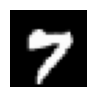

In [4]:
# Get a random image from the training set
train_path = path/'train'
img_files = list((train_path/'7').ls())

# Python Imaging Library (PIL) is a library for opening, manipulating, and saving many different image file formats.  
# A fork of it called Pillow is often used.  PIL comes with our import of fastai.vision.all.
img = PILImage.create(img_files[0])
print(f"This is a handwritten digit 7")
img.show(); 
# without this semi-colon, "<Axes: >" will also be printed out.  This comes from matplotlib, which is what PIL uses under the hood to display images.  It is the default axes object that was created for the plot.

In [5]:
dls = ImageDataLoaders.from_folder(path, valid='valid')

dls stands for DataLoaders.
	•	It's a wrapper around two PyTorch DataLoaders:
	•	One for training (dls.train)
	•	One for validation (dls.valid)

fastai provides the .from_folder method to quickly create this from a directory structure like:
```
    path/
    ├── train/
    │   ├── 3/
    │   ├── 7/
    ├── valid/
        ├── 3/
        ├── 7/
````

In [6]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(1) # 1 means to train for only 1 epoch (a complete pass through the entire training dataset)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.301025,0.155872,0.950932,00:48


epoch,train_loss,valid_loss,accuracy,time
0,0.049529,0.035846,0.989696,01:48


ResNet
ResNet-18 from Deep Residual Learning for Image Recognition <https://arxiv.org/abs/1512.03385>.
ResNet18 is a pre-trained model that was originally trained on ImageNet, which contains 1000 different classes of general images.

The fine_tune() method is a fastai convenience method that implements a specific training strategy:
1. It first freezes the pre-trained layers and trains only the new classification head
2. Then it unfreezes all layers and trains the entire model
3. It automatically adjusts learning rates and other training parameters
This is why it's called "fine-tuning" - we're taking a pre-trained model (ResNet18) 
and adapting it to our specific task (recognizing handwritten digits 3 and 7).

'head'
In the context of deep learning and transfer learning, the "head" refers to the final layers 
of a neural network that are responsible for making the specific predictions for your task.

In this case:
ResNet18 is a pre-trained model that was originally trained on ImageNet (a large dataset of general images)
The "head" is the new classification layer(s) that we add on top of ResNet18 to make it work for our specific task (classifying digits 3 and 7)

Think of it like this:

The main body of ResNet18 (the "backbone") has learned to extract useful features from images
The "head" is like a new brain that we add on top to interpret these features for our specific task

When we say "train only the new classification head", we mean:
Keep all the pre-trained ResNet18 layers frozen (unchanged)
Only train the new final layers that we added to classify our digits

This is a common transfer learning strategy because:
The pre-trained backbone already knows how to extract useful features from images
We only need to train the head to interpret these features for our specific task
This is much faster and requires less data than training the entire network from scratch

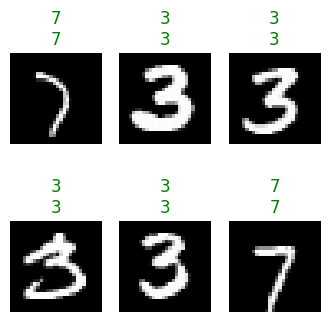

In [7]:
learn.show_results(max_n=6, figsize=(4, 4))

On top of each number image, there are two green numbers.  The first is actual value (of the hand-written number), the 2nd is predicted value.  

## Summary

In this tutorial, we've covered:
- How to set up a local environment for fastai
- How to load and preprocess the MNIST dataset
- How to build a simple image classification model
- How to train and evaluate the model
- How to make predictions with the trained model

In the next tutorial, we'll explore some more complex topics.  Stay tuned and happy Saturday.